<a href="https://colab.research.google.com/github/wahyunirosyidah/Pemanfaatan-Algoritma-CNN-untuk-Klasifikasi-Jenis-Noken/blob/main/InceptionV3_Tanpa_Optimasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO
from ipywidgets import widgets
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/SKRIPSI AYU'

Mounted at /content/drive
/content/drive/MyDrive/SKRIPSI AYU


In [ ]:
# Directory Path
BASE_DIR = 'Dataset Binary'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train=f'{BASE_DIR}/train'
print(f"Train Directory: {sorted(os.listdir(data_train))}")
data_validation=f'{BASE_DIR}/valid'
print(f"Valid Directory: {sorted(os.listdir(data_validation))}")

Base Directory: ['train', 'valid']
Train Directory: ['Bitu Agia', 'Junum Ese']
Valid Directory: ['Bitu Agia', 'Junum Ese']


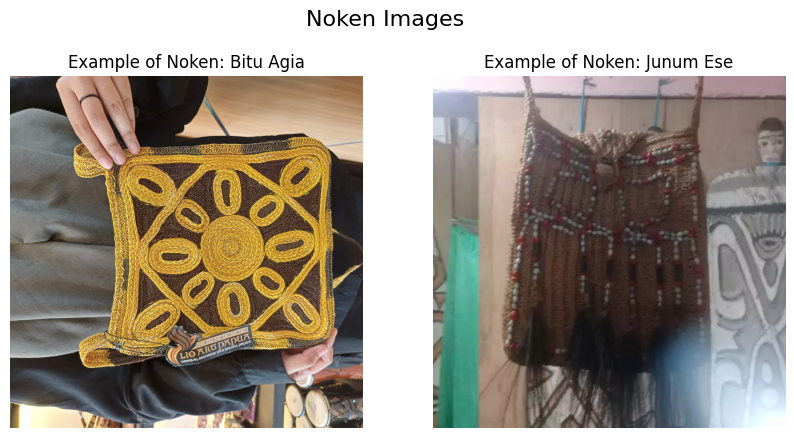

In [ ]:
# Plot noken Images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Noken Images', fontsize=16)

# List of noken
noken_list = os.listdir(data_train)
# Plot images for each noken
for i, noken in enumerate(noken_list):
    dir_path = f'{data_train}/{noken}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    # row, col = divmod(i, 3)
    axes[i].imshow(img)
    axes[i].set_title(f'Example of Noken: {noken}')
    axes[i].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(noken_list), 9):
    row, col = divmod(jj, 3)
    axes[i].axis('off')

plt.show()

# Prepocessing Data

In [ ]:
BATCH_SIZE=32
IMAGE_SIZE=299
LABEL_MODE='binary'

# Prepare the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Prepare the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 400 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


## Augmentation dan Rescaling

In [ ]:
FILL_MODE='reflect'

data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomShear(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)

])

data_rescaling = tf.keras.layers.Rescaling(1./255)

In [ ]:
def preprocess_train(images, labels):
    images = data_augmentation(images, training=True)
    images = data_rescaling(images)
    return images, labels

def preprocess_val(images, labels):
    images = data_rescaling(images)
    return images, labels

train_dataset = train_dataset.map(preprocess_train)
validation_dataset = validation_dataset.map(preprocess_val)


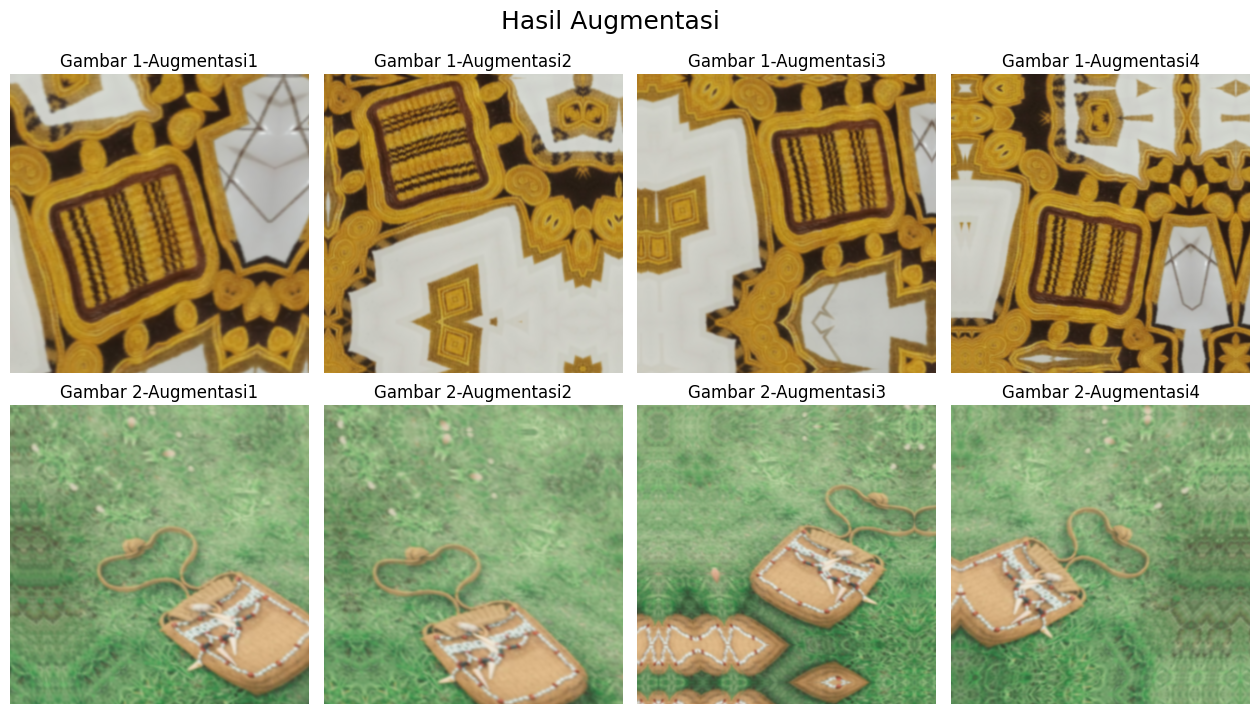

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Ambil satu batch dan dua gambar pertama
images, labels = next(iter(train_dataset))
samples = images[:2]

# Buat grid 2 baris × 4 kolom dengan figsize lebih lebar
fig, axes = plt.subplots(2, 4, figsize=(16, 8), squeeze=False)
fig.suptitle("Hasil Augmentasi", fontsize=18)

for row, img in enumerate(samples):
    for col in range(4):
        aug = data_augmentation(tf.expand_dims(img, 0), training=True)[0]
        axes[row, col].imshow(aug.numpy())
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Gambar {row+1}-Augmentasi{col+1}', fontsize=12)

# Atur jarak antar subplot
plt.subplots_adjust(wspace=0.05, hspace=0.1, top=0.90)

plt.show()


## Optimation

In [ ]:
# #Optimasi
# SHUFFLE_BUFFER_SIZE=500
# PREFETCH_BUFFER_SIZE=tf.data.AUTOTUNE

# train_dataset_final=(
#     train_dataset
#     .cache()
#     .shuffle(SHUFFLE_BUFFER_SIZE)
#     .prefetch(PREFETCH_BUFFER_SIZE)
# )

# validation_dataset_final=(
#     validation_dataset
#     .cache()
#     .prefetch(PREFETCH_BUFFER_SIZE)
# )

# Modelling

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet'
                                               )
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# # Membangun Model
def create_model(base_model):
    inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_output = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Buat Model
    model = tf.keras.Model(inputs, outputs)
    return model


In [ ]:
model = create_model(base_model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,697 (84.17 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

In [ ]:
# Constant for epochs
EPOCHS = 50

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

# Mulai menghitung waktu
start_time_no_optim = time.time()

# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    verbose=1
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.5869 - loss: 0.7921 - val_accuracy: 0.8500 - val_loss: 0.5725
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6972 - loss: 0.6661 - val_accuracy: 0.8800 - val_loss: 0.5096
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7809 - loss: 0.4567 - val_accuracy: 0.9100 - val_loss: 0.4597
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8357 - loss: 0.3580 - val_accuracy: 0.9400 - val_loss: 0.4061
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8472 - loss: 0.3631 - val_accuracy: 0.9600 - val_loss: 0.3594
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8739 - loss: 0.3239 - val_accuracy: 0.9500 - val_loss: 0.3383
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8958 - loss: 0.2590 - val_accuracy: 0.9400 - val_loss: 0.3209
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9144 - loss: 0.2336 - val_accuracy: 0.9600 - val_loss

In [ ]:
#Berhenti menghitung waktu
end_time_no_optim = time.time()

# Evaluation

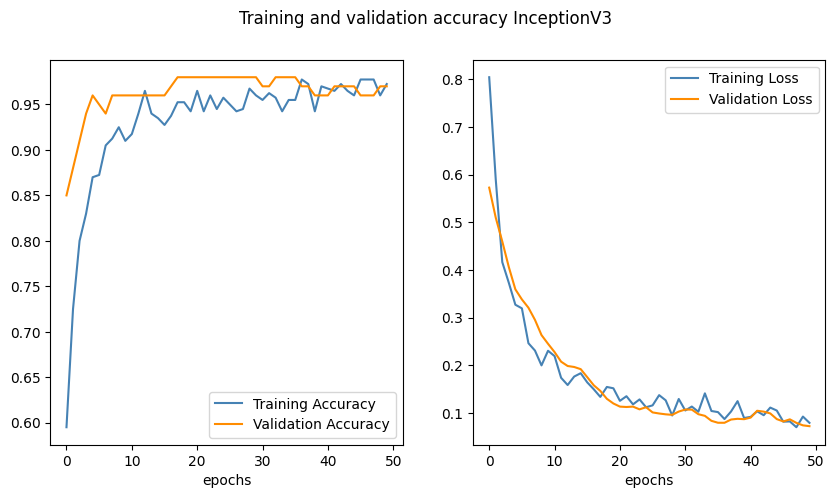

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy InceptionV3')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'steelblue', label="Training " + label)
    ax[i].plot(epochs, data[1], 'darkorange', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

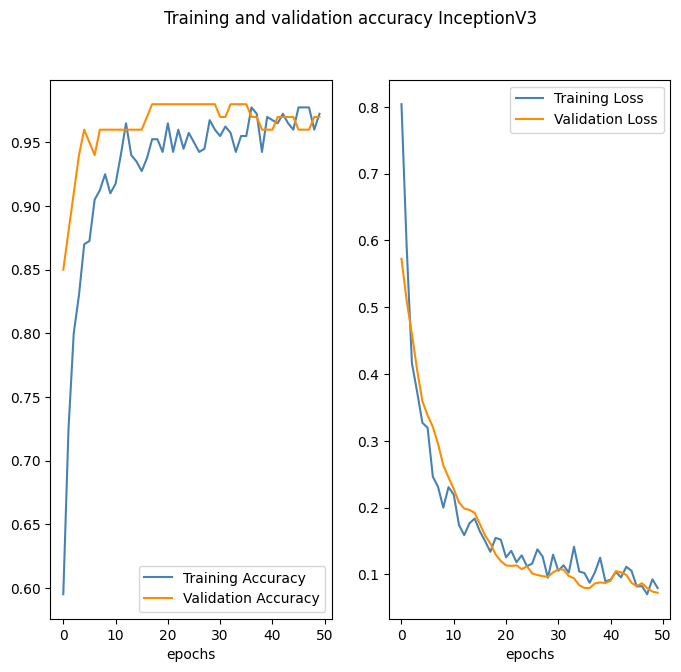

In [ ]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(8, 7))
fig.suptitle('Training and validation accuracy InceptionV3')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'steelblue', label="Training " + label)
    ax[i].plot(epochs, data[1], 'darkorange', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:

# Hitung jumlah file di dataset validasi
num_test_files = sum([len(files) for _, _, files in os.walk(data_validation)])
num_test_files = sum([len(files) for _, _, files in os.walk(data_train)])
num_test_steps = num_test_files // BATCH_SIZE  # Total batch yang akan dievaluasi

# Evaluasi model
loss, acc = model.evaluate(train_dataset, steps=num_test_steps, verbose=1)
val_loss, val_acc = model.evaluate(validation_dataset, steps=num_test_steps, verbose=1)

print(f"Train Loss: {loss * 100:.2f} %")
print(f"Train Accuracy: {acc * 100:.2f} %")
print(f"Validation Loss: {val_loss * 100:.2f} %")
print(f"Validation Accuracy: {val_acc * 100:.2f} %")

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9902 - loss: 0.0474
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9697 - loss: 0.0727 
Train Loss: 5.12 %
Train Accuracy: 98.70 %
Validation Loss: 7.27 %
Validation Accuracy: 97.00 %


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
duration = end_time_no_optim - start_time_no_optim
print(f"Waktu pelatihan tanpa optimasi: {duration:.2f} detik")

Waktu pelatihan tanpa optimasi: 1556.33 detik


In [ ]:
minutes, seconds = divmod(duration, 60)
print(f"Waktu pelatihan: {int(minutes)} menit {seconds:.2f} detik")

Waktu pelatihan: 25 menit 56.33 detik


In [ ]:
# Menghitung durasi dalam detik
duration_in_seconds = end_time_no_optim - start_time_no_optim

# Mengubah durasi ke dalam format menit dan detik
minutes = int(duration_in_seconds // 60)
seconds = int(duration_in_seconds % 60)

# Menampilkan durasi pelatihan
print(f"Waktu pelatihan tanpa optimasi: {minutes} menit {seconds} detik")

Waktu pelatihan tanpa optimasi: 25 menit 56 detik


Found 400 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


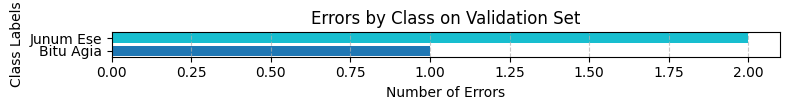

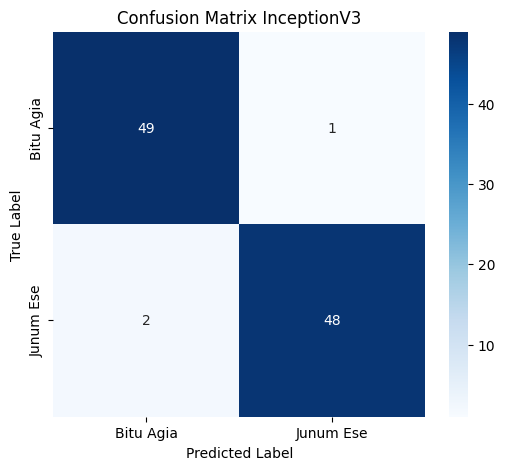

Classification Report InceptionV3:
              precision    recall  f1-score   support

   Bitu Agia       0.96      0.98      0.97        50
   Junum Ese       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
# Simpan class names
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    seed=42
)
class_names = raw_train_dataset.class_names

# Evaluasi Model
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int))  # true labels
    y_pred.extend((preds > 0.5).astype(int).flatten())  # binary predictions

# Convert to array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Hitung error per class (0 dan 1)
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

# Label kelas 0 dan 1
filtered_labels = [label for label, errors in zip(class_names, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

# Visualisasi Errors by Class
if len(filtered_labels) > 0:
    colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_labels)))
    plt.figure(figsize=(8, len(filtered_labels) * 0.6))
    plt.barh(filtered_labels, filtered_errors, color=colors)
    plt.title('Errors by Class on Validation Set', fontsize=12)
    plt.xlabel('Number of Errors', fontsize=10)
    plt.ylabel('Class Labels', fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kelas yang memiliki error!")

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix InceptionV3')
plt.show()

# Classification Report
print("Classification Report InceptionV3:")
print(classification_report(y_true, y_pred, target_names=class_names))


Found 400 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


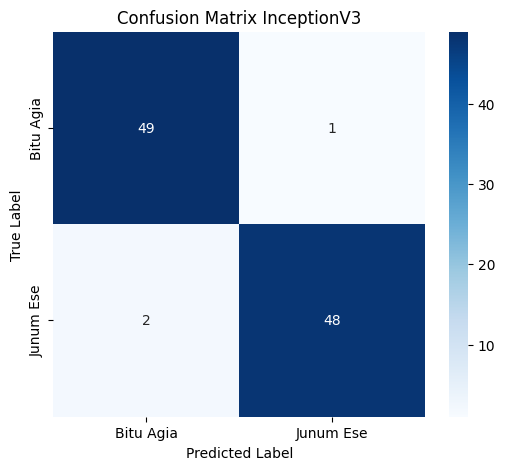

Classification Report InceptionV3:
              precision    recall  f1-score   support

   Bitu Agia       0.96      0.98      0.97        50
   Junum Ese       0.98      0.96      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Simpan class names
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE,
    seed=42
)
class_names = raw_train_dataset.class_names

# Evaluasi Model
y_true = []
y_pred = []

for images, labels in validation_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy().astype(int))  # true labels
    y_pred.extend((preds > 0.5).astype(int).flatten())  # binary predictions

# Convert to array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix InceptionV3')
plt.show()

# Classification Report
print("Classification Report InceptionV3:")
print(classification_report(y_true, y_pred, target_names=class_names))
